In [1]:
import pandas as pd
import numpy as np
import cooler
import cooltools
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import matplotlib
import pickle
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [3]:
from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
load_dotenv()

True

In [4]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

In [5]:
path_to_maps = os.getenv('PATH_TO_MAPS')

colors = {'iPSC-derived neurons' : '#469433',
        'Stem-like cells' : 'dimgrey',
        'Fetal neurons' : '#a85858',
        'Post-mortem neurons' : '#034e91'}

# 1. Get data for scaling

In [7]:
exp_dict = {}
for cl in [i for i in os.listdir(path_to_maps) if '.mcool' in i]:
    print('start '+ cl.split('.')[0])
    clr_ = cooler.Cooler(path_to_maps+cl+'::/resolutions/5000')
    exp = cooltools.expected_cis(
                    clr=clr_,
                    smooth=True,
                    aggregate_smoothed=True,
                    nproc=20
                )
    exp_dict[cl.split('.')[0]] = exp

start Ballerino2022_NES_5kb
start Lu2020_iPSC_NeuNplus
start Rahman2023_FetalBrain
start Zaghi2023_iPSC_NeuNplus
start Hu2021_NeuNplus
start Ballerino2022_iPSC_NeuNplus
start Rahman2023_NeuNplus
start Lu2020_iPSC_5kb
start Our_data_iPSC_NeuNplus
start Heffel_infant
start Wu2021_iPSC_NeuNplus
start Tian2023_NeuNplus
start Ballerino2022_NPC_5kb
start Heffel_3T
start Heffel_2T
start Rajarajan_iPSC_NeuNplus
start Pletenev2024_NeuNplus
start Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI
start Rajarajan_iPSC_Glia_5kb
start Rajarajan_NPC_5kb
start Li2022_iPSC_NeuNplus
start Zaghi2023_NPC_5kb
start Heffel_adult


In [19]:
print('start Rahman2023_iPSC_NeuNplus')
clr_ = cooler.Cooler(
    f'/{path_to_maps}/Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI.sampled_exact.mcool::/resolutions/5000')
exp = cooltools.expected_cis(
                clr=clr_,
                smooth=True,
                aggregate_smoothed=True,
                nproc=20
            )
exp_dict['Rahman2023_iPSC_NeuNplus'] = exp

start Rahman2023_iPSC_NeuNplus


In [20]:
### save files
with open('./scaling_data/data_for_scaling.pkl', 'wb') as file:
    pickle.dump(exp_dict, file)

### load files
with open('./scaling_data/data_for_scaling.pkl', 'rb') as file:
    exp_dict = pickle.load(file)


In [13]:
groups = {
'Stem-like cells': ['Ballerino2022_NPC_5kb','Zaghi2023_NPC_5kb', 'Rajarajan_NPC_5kb','Ballerino2022_NES_5kb'],
'iPSC-derived neurons': ['Zaghi2023_iPSC_NeuNplus','Rajarajan_iPSC_NeuNplus','Our_data_iPSC_NeuNplus',
                         'Ballerino2022_iPSC_NeuNplus','Li2022_iPSC_NeuNplus','Rahman2023_iPSC_NeuNplus',
                        'Wu2021_iPSC_NeuNplus'],
'Fetal neurons': ['Heffel_infant','Heffel_2T', 'Heffel_3T','Rahman2023_FetalBrain'],
'Post-mortem neurons': ['Heffel_adult', 'Pletenev2024_NeuNplus', 'Rahman2023_NeuNplus','Hu2021_NeuNplus', 'Tian2023_NeuNplus']}

In [27]:
datasets = [e for i in list(groups.values()) for e in i ]
assert  set(datasets) - set(list(exp_dict.keys())) == set()

In [28]:
new_dict = {}
for gr in groups.keys():
    smpls = groups[gr]
    new_df = {i : exp_dict[smpls[0]][i].to_list() for i in exp_dict[smpls[0]].columns}
    new_df = pd.DataFrame.from_dict(new_df)

    for k in smpls:
        new_df['balanced.avg.smoothed'] += exp_dict[k]['balanced.avg.smoothed']
        new_df['balanced.avg.smoothed.agg'] += exp_dict[k]['balanced.avg.smoothed.agg']
        
    new_df['balanced.avg.smoothed'] = new_df['balanced.avg.smoothed']/len(smpls)
    new_df['balanced.avg.smoothed.agg'] = new_df['balanced.avg.smoothed.agg']/len(smpls)
    new_dict[gr] = new_df

# 2. Plot scaling plot

In [29]:
def plot_scaling(new_dict, save_name=None, res_scal=5000):    
    f, axs = plt.subplots(2, 1, dpi=150, sharex=True, gridspec_kw={'height_ratios':[3, 1]}, 
                          figsize=(2.5, 4))               
    linestyles = {'R1': "solid", 
                  'R2': "dashed", 
                  'R3': 'dashdot', 
                  'R4': 'dotted'}
    i=0
    for name in new_dict.keys():
        print(name)
        new_dict[name] = new_dict[name][~new_dict[name]['region1'].isin(['chrX', 'chrY', 'chrM'])]
        new_dict[name] = new_dict[name][~new_dict[name]['region2'].isin(['chrX', 'chrY', 'chrM'])]    
        new_dict[name].loc[:, 's_bp'] = new_dict[name]['dist'] * res_scal
        new_dict[name].loc[new_dict[name]['dist'] < 2, 'balanced.avg.smoothed'] = np.nan
        new_dict[name].loc[:, 'balanced.avg.smoothed.norm'] = new_dict[name]['balanced.avg.smoothed'] / new_dict[name]['balanced.avg.smoothed'].values[2]
        der = np.gradient(np.log(new_dict[name]['balanced.avg.smoothed.norm']),np.log(new_dict[name]['s_bp']))    
        ax = axs[0]
        ax.plot([3e6, 3e6], [1e-4, 1], 'k--', alpha=0.3)
        ax.loglog(
            new_dict[name]['s_bp'],
            new_dict[name]['balanced.avg.smoothed.norm'],
            color=colors[name],
            label=name)    
        ax.set(ylabel='Contact frequency')
        ax.set_xlim([4000, 2e8])
        ax.set_ylim([1e-4, 1])
        ax.set_adjustable("box")
        ax.set_aspect(1)
        ax.grid(lw=0.5)
        ax.legend(bbox_to_anchor=(1.08, 1.05));
    
        ax = axs[1]
        ax.plot([3e6, 3e6], [-2, -0.25], 'k--', alpha=0.3)
        ax.semilogx(
            new_dict[name]['s_bp'],
            der,
            color=colors[name])
        ax.set(xlabel='Loci separation, bp',
            ylabel='Slope')    
        ax.grid(lw=0.5)
        ax.set_xticks([1e4, 1e5, 1e6, 1e7, 1e8], minor=False)
        ax.set_ylim([-2, 1])
        if save_name:
            plt.savefig(f'./general_chromatin_analysis_visualizations/{save_name}.pdf', dpi=600, bbox_inches='tight', format='pdf')
    plt.show()


In [30]:
def plot_scaling_aggregated(new_dict, save_name=None, res_scal=5000):    
    f, axs = plt.subplots(2, 1, dpi=150, sharex=True, gridspec_kw={'height_ratios':[3, 1]}, 
                          figsize=(2.5, 4))              
    linestyles = {'R1': "solid", 'R2': "dashed", 'R3': 'dashdot', 'R4': 'dotted'}  
    
    i=0
    for name in new_dict.keys():    
        new_dict[name] = new_dict[name][~new_dict[name]['region1'].isin(['chrX', 'chrY', 'chrM'])]
        new_dict[name] = new_dict[name][~new_dict[name]['region2'].isin(['chrX', 'chrY', 'chrM'])]        
        new_dict[name].loc[:, 's_bp'] = new_dict[name]['dist'] * res_scal
        new_dict[name].loc[new_dict[name]['dist'] < 2, 'balanced.avg.smoothed.agg'] = np.nan
        new_dict[name].loc[:, 'balanced.avg.smoothed.agg.norm'] = new_dict[name]['balanced.avg.smoothed.agg'] / new_dict[name]['balanced.avg.smoothed.agg'].values[2]
    
        der = np.gradient(np.log(new_dict[name]['balanced.avg.smoothed.agg.norm']),np.log(new_dict[name]['s_bp']))   
        
        ax = axs[0]
        ax.plot([3e6, 3e6], [1e-4, 1], 'k--', alpha=0.3)
        ax.loglog(
            new_dict[name]['s_bp'],
            new_dict[name]['balanced.avg.smoothed.agg.norm'],
            color=colors[name],
            label=name)
    
        ax.set(     ylabel='Contact frequency')
    
        ax.set_xlim([4000, 2e8])
        ax.set_ylim([1e-4, 1])
        ax.set_adjustable("box")
        ax.set_aspect(1)
        ax.grid(lw=0.5)
        ax.legend(bbox_to_anchor=(1.08, 1.05));
        ax = axs[1]
        ax.plot([3e6, 3e6], [-2, -0.25], 'k--', alpha=0.3)
        ax.semilogx(
            new_dict[name]['s_bp'],
            der,
            color=colors[name])
        ax.set(
            xlabel='Loci separation, bp',
            ylabel='Slope')    
        ax.grid(lw=0.5)
        ax.set_xticks([1e4, 1e5, 1e6, 1e7, 1e8], minor=False)
        ax.set_ylim([-2, -0.0])
        if save_name:
            plt.savefig(f'./general_chromatin_analysis_visualizations/{save_name}.pdf', dpi=600, bbox_inches='tight', format='pdf')
    plt.show()
    

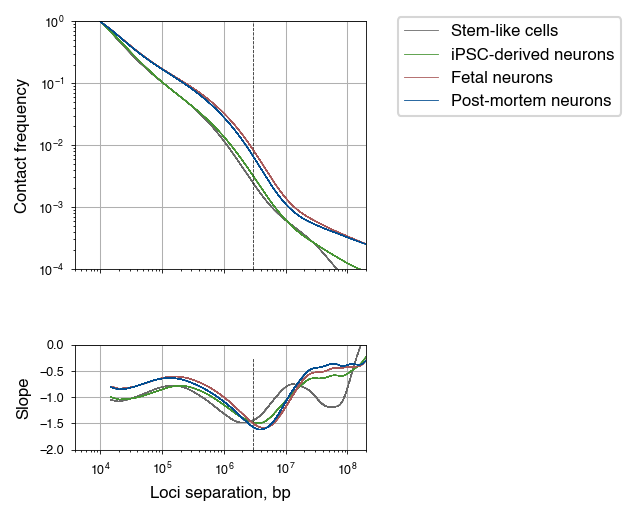

In [33]:
plot_scaling_aggregated(new_dict, save_name="scaling_by_groups_upd", res_scal=5000)

Stem-like cells
iPSC-derived neurons
Fetal neurons
Post-mortem neurons


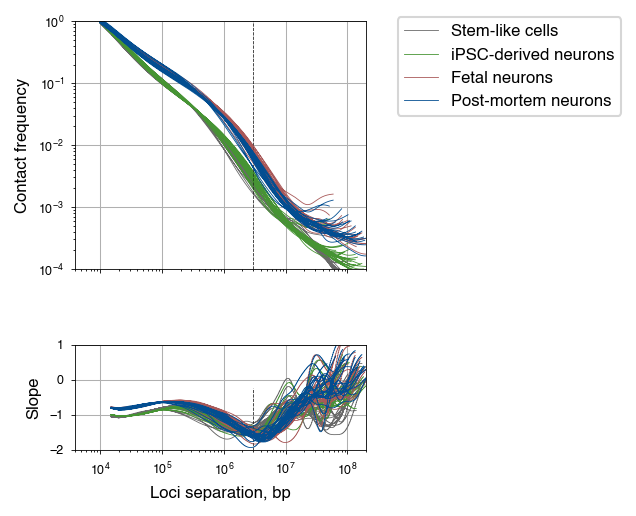

In [34]:
plot_scaling(new_dict, save_name="scaling_by_samples_upd", res_scal=5000)

# DLR

In [6]:
chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17',
       'chr18', 'chr19', 'chr20', 'chr21', 'chr22']

In [7]:
files = [i for i in os.listdir(path_to_maps) if '.mcool' in i]

In [9]:
dic={}
for f in files:
    coolpath = path_to_maps+f+'::/resolutions/100000'
    c = cooler.Cooler(coolpath)
    name = f.split('/')[-1].split('.')[0]
    print('start',name)
    DLR=[]    
    for ch in chroms:
        m=c.matrix(balance=True).fetch(ch)
        
        st1=0
        en2=len(m)

        for i in range(len(m)):
            a=m[i]
            en1=max(0,i-12)
            st2=min(i+12,len(a))
            l=np.nansum(a[en1:st2+1])
            d=np.nansum(a[0:en1])+np.nansum(a[st2+1:]) 
            DLR.append(np.log2(d/l))    
    dic[name]=DLR
dic_df = pd.DataFrame.from_dict(dic)
dic_df.head()

In [11]:
### save files
with open('./scaling_data/data_for_dlr.pkl', 'wb') as file:
    pickle.dump(dic_df, file)
    
### load files
with open('./scaling_data/data_for_dlr.pkl', 'rb') as file:
    dic_df = pickle.load(file)


In [18]:
df_box_dict = {
    'values':[],
    'group':[]
}

for gr in groups.keys():
    dff = dic_df[groups[gr]]
    for col in dff.columns:

        df_box_dict['values'] += dff[col].to_list()
        df_box_dict['group'] += [gr]*len(dff[col])


df_box_n = pd.DataFrame.from_dict(df_box_dict)
df_box_n = df_box_n.dropna()

In [19]:
cnt=0
groups = df_box_n.group.unique()
for group1 in groups[cnt:]:
    for group2 in groups:
        if group1 != group2:
            print(group1, " vs ", group2)
            group1_values = df_box_n[df_box_n['group'] == group1]['values']
            group2_values = df_box_n[df_box_n['group'] == group2]['values']
            
            t_statistic, p_value = stats.ttest_ind(group1_values, group2_values, equal_var=False)
            print(f'T statistic: {t_statistic}')
            print(f'P-value: {p_value}')

            cnt+=1

Stem-like cells  vs  iPSC-derived neurons
T statistic: -142.5639049896836
P-value: 0.0
Stem-like cells  vs  Fetal neurons
T statistic: -329.0253024658658
P-value: 0.0
Stem-like cells  vs  Post-mortem neurons
T statistic: -259.5961401545278
P-value: 0.0
iPSC-derived neurons  vs  Stem-like cells
T statistic: 142.5639049896836
P-value: 0.0
iPSC-derived neurons  vs  Fetal neurons
T statistic: -219.12331911679937
P-value: 0.0
iPSC-derived neurons  vs  Post-mortem neurons
T statistic: -136.7698446424683
P-value: 0.0
Fetal neurons  vs  Stem-like cells
T statistic: 329.0253024658658
P-value: 0.0
Fetal neurons  vs  iPSC-derived neurons
T statistic: 219.12331911679937
P-value: 0.0
Fetal neurons  vs  Post-mortem neurons
T statistic: 87.68533684020606
P-value: 0.0
Post-mortem neurons  vs  Stem-like cells
T statistic: 259.5961401545278
P-value: 0.0
Post-mortem neurons  vs  iPSC-derived neurons
T statistic: 136.7698446424683
P-value: 0.0
Post-mortem neurons  vs  Fetal neurons
T statistic: -87.685336

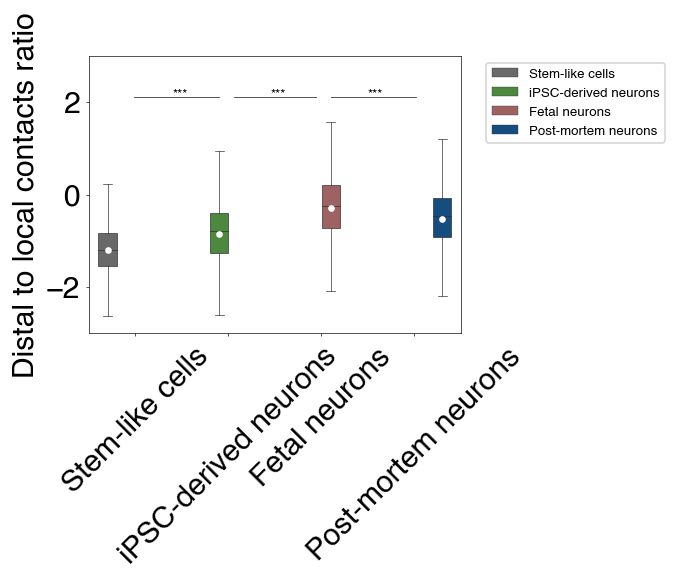

In [22]:
plt.figure(figsize=(4, 3), dpi=120)
sns.boxplot(data=df_box_n,x ='group', y= 'values', 
            order = ['Stem-like cells', 'iPSC-derived neurons', 'Fetal neurons', 'Post-mortem neurons'],
            palette = colors,
            showmeans=True,
            hue='group', 
            boxprops=dict(linewidth=0.4),
                 whiskerprops=dict(linewidth=0.4),
                 capprops=dict(linewidth=0.4),
                 medianprops=dict(linewidth=0.4),
                 meanprops={"marker": "o",
                            "markeredgecolor": "white",
                            "markerfacecolor": "white",
                            "markersize": "3"},
            showfliers=False,
           )
plt.ylabel('Distal to local contacts ratio',fontsize = 18)
plt.xlabel('',fontsize = 18)
plt.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1.5,1))
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(rotation=45)
plt.ylim(-3, 3)

plt.axhline(y=2.1,xmin=0.65,xmax=0.88, color='black',linestyle='-')
plt.axhline(y=2.1,xmin=0.39,xmax=0.61, color='black',linestyle='-')
plt.axhline(y=2.1,xmin=0.12,xmax=0.35, color='black',linestyle='-')

plt.text(y=2.12,x=0.4,s='***',rotation='horizontal')
plt.text(y=2.12,x=1.45,s='***',rotation='horizontal')
plt.text(y=2.12,x=2.5,s='***',rotation='horizontal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(f'./general_chromatin_analysis_visualizations/dlr_upd.pdf', dpi=600, bbox_inches='tight', format='pdf')

In [21]:
for g1 in df_box_n['group'].unique():
    for g2 in df_box_n['group'].unique():
        if g1 != g2:
            U1, p = mannwhitneyu(df_box_n[df_box_n['group']==g1]['values'],df_box_n[df_box_n['group']==g2]['values'], method="auto")
            print(g1, g2, p)

Stem-like cells iPSC-derived neurons 0.0
Stem-like cells Fetal neurons 0.0
Stem-like cells Post-mortem neurons 0.0
iPSC-derived neurons Stem-like cells 0.0
iPSC-derived neurons Fetal neurons 0.0
iPSC-derived neurons Post-mortem neurons 0.0
Fetal neurons Stem-like cells 0.0
Fetal neurons iPSC-derived neurons 0.0
Fetal neurons Post-mortem neurons 0.0
Post-mortem neurons Stem-like cells 0.0
Post-mortem neurons iPSC-derived neurons 0.0
Post-mortem neurons Fetal neurons 0.0
